<a href="https://colab.research.google.com/github/Kaiziferr/deep_learning/blob/master/multilayer_perceptron/04_prediction_microcalcificaciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.constraints import max_norm

# **Descripcion**
---


Existen siete características donde una es la del status relacionada con los microcalcificaciones y no microcalcificaciones. El resto no dispongo información del todo, pero el conjunto es muy usado. Cabe resaltando que esté conjunto de datos es para aprendizaje propio.


# **Objetivos**
---
El objetivo es distinguir entre `microcalcificaciones` y `no microcalcificaciones` usando las características de un objeto segmentado determinado.

- No microcalcificaciones : caso negativo, o clase mayoritaria.
- Microcalcificaciones : caso positivo, o clase minoritaria.

Las `Microcalcificaciones`: Son depósitos diminutos de calcio en el tejido mamario que a menudo se observan en una mamografía.

https://medlineplus.gov/spanish/ency/article/002113.htm


Entender sobre las capas `Droput`



In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/mammography.csv', header=None)
data.head(5)

,0,1,2,3,4,5,6
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,'-1'
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,'-1'
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723,'-1'
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723,'-1'
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566,'-1'


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11183 entries, 0 to 11182
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       11183 non-null  float64
 1   1       11183 non-null  float64
 2   2       11183 non-null  float64
 3   3       11183 non-null  float64
 4   4       11183 non-null  float64
 5   5       11183 non-null  float64
 6   6       11183 non-null  object 
dtypes: float64(6), object(1)
memory usage: 611.7+ KB


- Las variables de entrenamiento (0:5) son de tipo númerico float
- La variable 6 que representa las microcalcificaciones es de tipo object (categorica)
- Hay 11183 registros y no se aprecia valores faltantes en ninguna columna


# **Split**
---

In [ ]:
data_values = data.values
X = data_values[:, :6]
y = data_values[:, 6]

In [ ]:
def plot_bars(data: np.ndarray, title: str= 'feature', x_size:int=6, y_size:int=4, font_size:int=15, 
              x_label:str='churm', y_label:str='no churm')->None:
  fig, ax = plt.subplots(figsize = (x_size, y_size))
  fig.suptitle(f'Count plot {title}', fontsize = font_size)
  sns.countplot(x = data, ax = ax)
  label, data_target = np.unique(data, return_counts=True)
  len_data = data.shape[0]
  pe = '{0:.2f}'.format(data_target[1]/len_data)
  ps = '{0:.2f}'.format(data_target[0]/len_data)
  x_l = list(ax.get_xticklabels())
  if x_l[0].get_text() == label[0]:
    ax.set_xticklabels([f'{ax.get_xticklabels()[0].get_text()}\n{ps}', f'{ax.get_xticklabels()[1].get_text()}\n{pe}'])
  elif x_l[0].get_text() == label[1]:
    ax.set_xticklabels([f'{ax.get_xticklabels()[0].get_text()}\n{pe}', f'{ax.get_xticklabels()[1].get_text()}\n{ps}'])
  ax.set(xlabel=x_label, ylabel=y_label)
  fig.show()

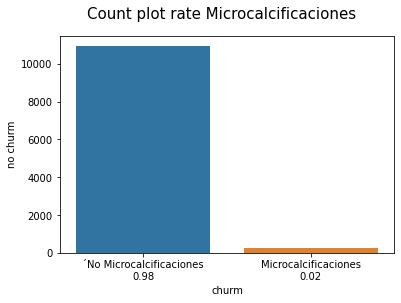

In [ ]:
plot_bars(np.where(y=="'1'", 'Microcalcificaciones', '´No Microcalcificaciones'), title = 'rate Microcalcificaciones')

Hay un serio **desbalance** en el conjunto de datos del 98% No Microcalcificaciones y un 2% Microcalcificaciones, es un desbalance severo.



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=741, shuffle=True)

In [ ]:
estimator = StandardScaler()
X_train_s = estimator.fit_transform(X_train)
X_test_s = estimator.transform(X_test)

In [ ]:
encoder = LabelEncoder()
y_train_s = encoder.fit_transform(y_train)
y_test_s = encoder.transform(y_test)

# **Model**
---

Se realizarón diversas iteraciones para llegar a la arquitectura propuesta para el presente modelo, cabe resaltar que no se realizo alguna comparativa, puesto que no es el proposito de está actividad.

In [ ]:
def model_seleccionado():
  model = Sequential()
  model.add(Dense(15, input_dim = 6, activation='relu', kernel_initializer='he_normal'))
  model.add(Dense(5,  activation='relu', kernel_initializer='he_normal'))
  model.add(Dense(2,  activation='relu', kernel_initializer='he_normal'))
  model.add(Dense(1, activation='sigmoid', kernel_initializer='he_normal'))
  model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
  return model

In [ ]:
model_seleccionado = model_seleccionado()
history = model_seleccionado.fit(X_train_s, y_train_s, epochs = 300, batch_size = 100, validation_data = (X_test_s, y_test_s), verbose = 0)

In [ ]:
def optimization_learning_curves(history: keras.callbacks.History, metrica, title: str= '', x_size:int=8, y_size:int=4, font_size:int=15, x_label:str='Epoch',y_label:str='Loss')->None:
  fig, ax = plt.subplots(figsize = (x_size, y_size))
  fig.suptitle(title, fontsize = font_size)
  ax.plot(history.history[metrica])
  ax.plot(history.history[f'val_{metrica}'])
  ax.set_xlabel(x_label, size = 12)
  ax.set_ylabel(y_label, size = 12)
  ax.legend(['Train', 'Test'], loc = 'upper left', fontsize = 12)
  ax.tick_params(labelsize = 12)
  fig.show()

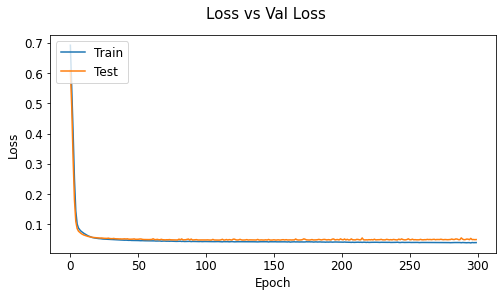

In [ ]:
optimization_learning_curves(history, metrica='loss', title='Loss vs Val Loss')

- El modelo tiene una brecha de generalización muy pequeña durante las epocas de entrenameinto

In [ ]:
y_pred = (model_seleccionado.predict(X_test_s)>0.5).astype('int32')
y_pred = np.reshape(y_pred, y_pred.shape[0])
y_pred

array([0, 0, 0, ..., 0, 0, 1], dtype=int32)

In [ ]:
def consufion_matrix(validation: np.ndarray, prediction:np.ndarray, 
                     title: str= 'Matriz de confusion', x_size:int=6, y_size:int=5, **kwards)->np.ndarray:
  matrix = metrics.confusion_matrix(validation, prediction)
  fig, ax = plt.subplots(nrows= 1, ncols=  1, figsize = (x_size,y_size))
  sns.heatmap(matrix, annot=True, ax = ax, cmap=plt.cm.Blues, fmt = 'g', annot_kws={'size': 13})
  ax.set_title(title, size = 13)
  v = list(kwards.values())
  k = list(kwards.keys())
  if ax.get_xticklabels()[0].get_text() == v[0]:
    ax.xaxis.set_ticklabels([k[0], k[1]])
    ax.yaxis.set_ticklabels([k[0], k[1]])
  else:
    ax.xaxis.set_ticklabels([k[1], k[0]])
    ax.yaxis.set_ticklabels([k[1], k[0]])
  ax.tick_params(labelsize = 13)
  fig.show()
  return matrix

In [ ]:
keys = encoder.classes_
print(keys)
values = encoder.transform(encoder.classes_)
dictionary = dict(zip(keys, values))
print(dictionary)

["'-1'" "'1'"]
{"'-1'": 0, "'1'": 1}


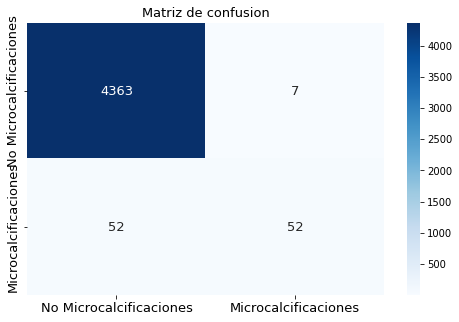

In [ ]:
matrix = consufion_matrix(y_test_s, y_pred, x_size = 8, **{'Microcalcificaciones':1, 'No Microcalcificaciones':0})

Para tener pocos registro de microcalcificaciones en coparación con la clase negativa (no microcalcificaciones) el modelo tiene un buen rendimiento a la hora de predecir la clase de interes, por lo tanto puede detecatar de manera correcata la clase de interes, de la misma manera tiene un número de falso negativos error tipo II.


In [ ]:
# Metricas
def metricas(validation: np.ndarray, prediction:np.ndarray, matrix:np.ndarray, label:list=[1])->None:
  accuracy = '%.3f' % metrics.accuracy_score(validation, prediction)
  kappa = '%.3f' % metrics.cohen_kappa_score(validation, prediction)
  precision = '%.3f' % metrics.precision_score(validation, prediction, labels=label, average="macro")
  recall = '%.3f' % metrics.recall_score(validation, prediction, labels=label, average="macro")
  f1_score = '%.3f' % metrics.f1_score(validation, prediction, labels=label, average="macro")

  print(f'Accuracy  :   {accuracy}')
  print(f'Kappa     :   {kappa}')
  print(f'predicción enfermos')
  print(f'Precision:   {precision}')
  print(f'Recall    :   {recall}')

  VN, FP = 0, 0 
  if label == [1]:
    VN = matrix[0,0]
    FP = matrix[0,1]
  else:
    VN = matrix[0,0]
    FP = matrix[0,1]
  specificity = VN/(VN+FP)
  specificity = '%.3f' %  specificity

  print(f'Specificity:   {specificity}')
  print(f'F1-score   :   {f1_score}')
  return accuracy, kappa, precision, recall, f1_score, specificity

In [ ]:
accuracy, kappa, precision, recall, f1_score, specificity = metricas(y_test_s, y_pred, matrix)

Accuracy  :   0.987
Kappa     :   0.632
predicción enfermos
Precision:   0.881
Recall    :   0.500
Specificity:   0.998
F1-score   :   0.638


# **Droput** 
---

Utilizar el modelo seleccionado, aunque está vez aplicare capas con dropout

In [ ]:
# Tasa de droput 
# Se impone una restricción en los pesos para cada capa oculta con la norma maxima de los pesos para que no exceda 3, 
# estableciendo el argumento de kernel_constraint en la clase Dense.
# Aumenta la tasa de aprendizaje y el momentum.

def model_dropout():
  model = Sequential()
  model.add(Dropout(0.1, input_dim = 6))
  model.add(Dense(15, activation='relu', kernel_initializer='he_normal', kernel_constraint=max_norm(3)))
  model.add(Dropout(0.1))
  model.add(Dense(5,  activation='relu', kernel_initializer='he_normal', kernel_constraint=max_norm(3)))
  model.add(Dense(2,  activation='relu', kernel_initializer='he_normal'))
  model.add(Dense(1, activation='sigmoid', kernel_initializer='he_normal'))
  model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
  return model

In [ ]:
model_seleccionado_dropout = model_dropout()
history_dropout = model_seleccionado_dropout.fit(X_train_s, y_train_s, epochs = 300, batch_size = 100, 
                                                 validation_data = (X_test_s, y_test_s), verbose = 0)

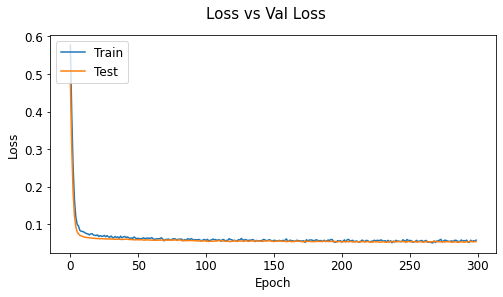

In [ ]:
optimization_learning_curves(history_dropout, metrica='loss', title='Loss vs Val Loss')

In [ ]:
y_pred_dropout = (model_seleccionado_dropout.predict(X_test_s)>0.5).astype('int32')
y_pred_dropout = np.reshape(y_pred_dropout, y_pred_dropout.shape[0])
y_pred_dropout

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

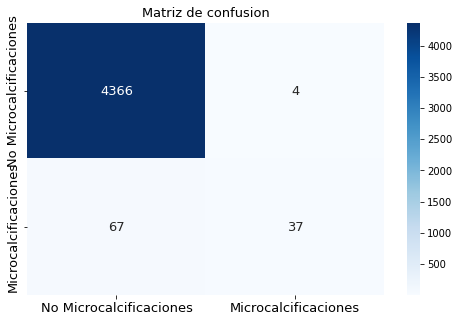

In [ ]:
matrix = consufion_matrix(y_test_s, y_pred_dropout, x_size = 8, **{'Microcalcificaciones':1, 'No Microcalcificaciones':0})

In [ ]:
accuracy, kappa, precision, recall, f1_score, specificity = metricas(y_test_s, y_pred, matrix)

Accuracy  :   0.987
Kappa     :   0.632
predicción enfermos
Precision:   0.881
Recall    :   0.500
Specificity:   0.999
F1-score   :   0.638


Pese a que se utilizo el dropout en algunas capas del mismo modelo utilizado anteriormente, no se evidencia una mejora sustancial en la predicción de microcalcificaciones. Al ser un problema tán critico no se podria poner en produccón con el rendimiento optenido hasta el momento, pese a que no hallamos medido el rendimiento. Claro bajo mi criterio, ya que como tal se deberia tambien tener encuenta otros factores como la opinión de un experto. 

Se requiere validar otras tecnicas que permitan mejorar el nivel de predicción. Recordenmos que esté es un actividad de `aprendizaje`.